In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()

Saving train-data.csv to train-data (2).csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test-data.csv to test-data (2).csv


In [ ]:
# 데이터 불러오기 및 칼럼 정렬

train = pd.read_csv('train-data.csv', index_col=0)
test = pd.read_csv('test-data.csv', index_col=0)

In [ ]:
# train, val, test 데이터로 나누기

from sklearn.model_selection import train_test_split

target = 'Price'

train, val = train_test_split(train, test_size=0.15, random_state=2)
train.shape, val.shape

((5116, 13), (903, 13))

In [ ]:
# 데이터 확인

train.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
2206,Hyundai i20 1.2 Era,Kolkata,2015,35000,Petrol,Manual,First,17.0 kmpl,1197 CC,80 bhp,5.0,NaN,3.40
5273,Tata Indica V2 DL BSIII,Hyderabad,2004,200000,Diesel,Manual,Second,17.88 kmpl,1396 CC,52.8 bhp,5.0,NaN,0.85
5301,BMW X1 sDrive20d,Delhi,2011,72000,Diesel,Automatic,First,17.05 kmpl,1995 CC,184 bhp,5.0,NaN,11.00
491,Hyundai Creta 1.6 CRDi AT SX Plus,Bangalore,2016,32000,Diesel,Automatic,First,17.01 kmpl,1582 CC,126.2 bhp,5.0,NaN,15.50
2657,Hyundai i10 Era,Ahmedabad,2012,60000,Petrol,Manual,Second,19.81 kmpl,1086 CC,68.05 bhp,5.0,NaN,2.65


In [ ]:
# 타입 확인

train.dtypes

Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object

In [ ]:
# 데이터 요약

train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,5116,1741,Mahindra XUV500 W8 2WD,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,5116,11,Mumbai,673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,5116,NaN,NaN,NaN,2013.35,3.27435,1998,2011,2014,2016,2019
Kilometers_Driven,5116,NaN,NaN,NaN,57590.5,38177.4,171,33781.2,53000,73000,775000
Fuel_Type,5116,5,Diesel,2737,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission,5116,2,Manual,3630,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Owner_Type,5116,4,First,4195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,5114,433,18.9 kmpl,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine,5088,143,1197 CC,508,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,5088,364,74 bhp,196,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# NaN 확인

train.isna().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 28
Power                  28
Seats                  34
New_Price            4413
Price                   0
dtype: int64

In [ ]:
# feature engineering

def engineering(df):
    # temp_df에 DataFrame 복사
    temp_df = df.copy()

    # Mileage 문자열을 실수형으로 변환 (km/kg -> kmpl)
    try:
        temp_df = temp_df.dropna(subset=['Mileage'])
    except:
        pass
    temp_df['Mileage'] = temp_df['Mileage'].apply(lambda x : x.split(' ')[0])
    temp_df['Mileage'] = temp_df['Mileage'].astype(float)
   
    # Owner_Type --> Rank type 변환
    filter_map = {'First' : 1, 'Second' : 2, 'Third' : 3, 'Fourth & Above' : 4}
    temp_df['Owner_Type'] = temp_df['Owner_Type'].replace(filter_map).astype(int)
   
    # Engine 및 Power type 실수형으로 변환
    temp_df['Engine'] = temp_df['Engine'].apply(lambda x : x.split(' ')[0] if type(x) != float else np.nan)
    temp_df['Engine'] = temp_df['Engine'].astype(float)
   
    temp_df['Power'] = temp_df['Power'].apply(lambda x : x.split(' ')[0] if type(x) != float and 'null' not in x else np.nan)
    temp_df['Power'] = temp_df['Power'].astype(float)
   
    # 자동차의 시트수로 채우기
    temp_df['Seats'] = df.Seats.fillna(4)
   
    # New_Price, Name, Location 칼럼 제거
    temp_df.drop(['New_Price', 'Name', 'Location'], axis=1, inplace=True)
  
    return temp_df

train = engineering(train)
val = engineering(val)

In [ ]:
# 4-1. 데이터 변환 확인

train.head()

,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
2206,2015,35000,Petrol,Manual,1,17.00,1197.0,80.00,5.0,3.40
5273,2004,200000,Diesel,Manual,2,17.88,1396.0,52.80,5.0,0.85
5301,2011,72000,Diesel,Automatic,1,17.05,1995.0,184.00,5.0,11.00
491,2016,32000,Diesel,Automatic,1,17.01,1582.0,126.20,5.0,15.50
2657,2012,60000,Petrol,Manual,2,19.81,1086.0,68.05,5.0,2.65


In [ ]:
# 4-2. Price 분포 확인

train.Price.describe()

count    5114.000000
mean        9.471707
std        10.940472
min         0.440000
25%         3.500000
50%         5.650000
75%        10.000000
max       120.000000
Name: Price, dtype: float64

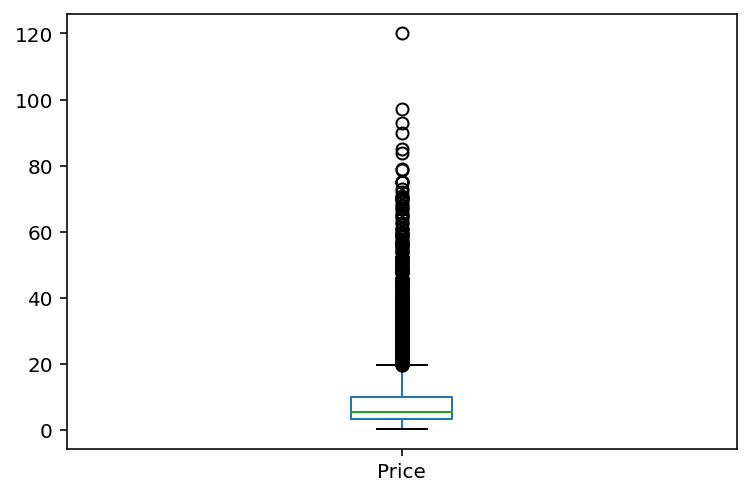

In [ ]:
train.Price.plot.box();

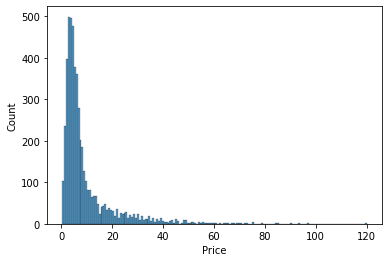

In [ ]:
%matplotlib inline

import seaborn as sns

sns.histplot(train.Price);

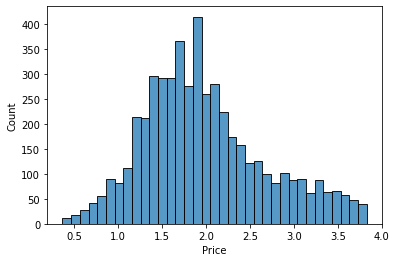

In [ ]:
# 이상치 제거

# get outlier 정렬
def get_outlier(df, col):
    outlier_idx = df.loc[df[col] > np.percentile(df[col], 98)].index
    return outlier_idx

# taget log 변환
def log_transform(df, col):
    df[col] = df[col].apply(lambda x : np.log1p(x))
    return df

# inverse target
def inverse_target(data):
    return np.expm1(data)

# 이상치 제거    
idx = get_outlier(train, target)
idx
train.drop(idx, axis=0, inplace=True)
idx = get_outlier(val, target)
val.drop(idx, axis=0, inplace=True)

# log transform
train = log_transform(train, target)
val = log_transform(val, target)

# 분포 변경 확인
sns.histplot(train.Price);

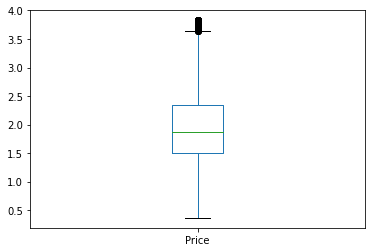

In [ ]:
train.Price.plot.box();

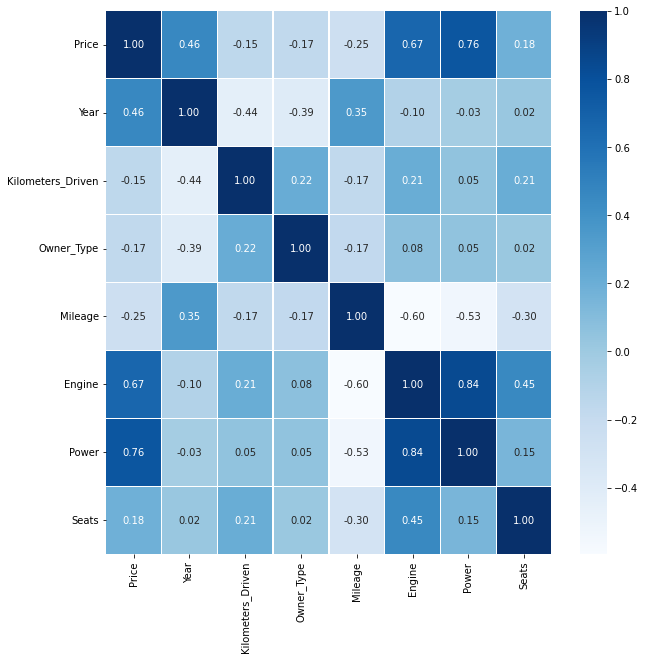

In [ ]:
# 상관관계 시각화

import matplotlib.pyplot as plt

new = train['Price']
train = train.drop(['Price'], axis = 1)
train = pd.concat([new, train], axis = 1)
plt.figure(figsize = (8,8))
sns.heatmap(data = train.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues');

In [ ]:
 # 타켓 설정

X_train = train.drop(target, axis=1)
y_train = train[target]
X_val = val.drop(target, axis=1)
y_val = val[target]
X_test = test.copy()

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((5015, 9), (884, 9), (1234, 12))

In [ ]:
!pip install --upgrade category_encoders

In [ ]:
# 교차 검증 (LinearRegression, Ridge, DecisionTreeRegressor, RandomForestRegressor)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold

linreg = LinearRegression()
ridge = Ridge()
dtreg = DecisionTreeRegressor()
rtreg = RandomForestRegressor()


scores = {}
models = [linreg, ridge, dtreg, rtreg]
model_names = ['LinearRegression', 'Ridge', 'DecisionTreeRegressor', 'RandomForestRegressor']
for idx, model in enumerate(models):
    if idx <= 1:
        pipe = make_pipeline(OneHotEncoder(use_cat_names=True),
                             SimpleImputer(),
                             StandardScaler(),
                             model)
        pipe.fit(X_train, y_train)
        acc = cross_val_score(pipe, X_train, y_train, scoring='r2', cv=10)
        scores[model_names[idx]] = acc
    if idx > 1:
        pipe = make_pipeline(OrdinalEncoder(),
                             SimpleImputer(),
                             model)
        pipe.fit(X_train, y_train)
        acc = cross_val_score(pipe, X_train, y_train, scoring='r2', cv=10)
        scores[model_names[idx]] = acc
results = pd.DataFrame(scores).T
results

,0,1,2,3,4,5,6,7,8,9
LinearRegression,0.835970,0.822557,0.866649,0.869529,0.843774,0.857472,0.844043,0.866058,0.859865,0.854146
Ridge,0.836089,0.822685,0.866641,0.869555,0.843766,0.857479,0.844040,0.866809,0.859340,0.854130
DecisionTreeRegressor,0.840542,0.819816,0.847385,0.889288,0.841927,0.845982,0.863654,0.828825,0.861704,0.827606
RandomForestRegressor,0.904387,0.899673,0.923151,0.933738,0.920653,0.929856,0.929653,0.911661,0.926889,0.911479


In [ ]:
# 모델별 score

results['mean'] = results.mean(axis=1)
result_df = results.sort_values(by='mean', ascending=False)
result_df

,0,1,2,3,4,5,6,7,8,9,mean
RandomForestRegressor,0.904387,0.899673,0.923151,0.933738,0.920653,0.929856,0.929653,0.911661,0.926889,0.911479,0.919114
Ridge,0.836089,0.822685,0.866641,0.869555,0.843766,0.857479,0.844040,0.866809,0.859340,0.854130,0.852053
LinearRegression,0.835970,0.822557,0.866649,0.869529,0.843774,0.857472,0.844043,0.866058,0.859865,0.854146,0.852006
DecisionTreeRegressor,0.840542,0.819816,0.847385,0.889288,0.841927,0.845982,0.863654,0.828825,0.861704,0.827606,0.846673


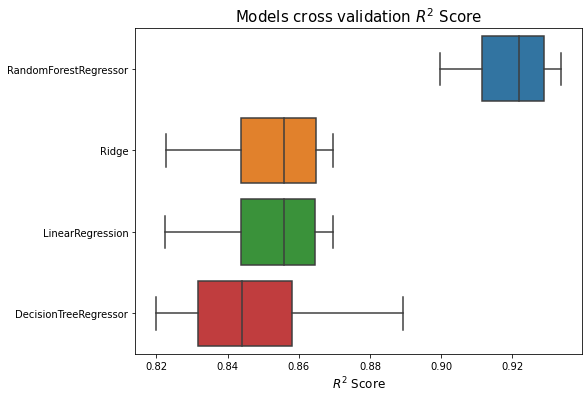

In [ ]:
result_df.drop('mean', axis=1, inplace=True)

plt.figure(figsize=(8, 6))
sns.boxplot(data=result_df.T, orient='h')
plt.title('Models cross validation $R^2$ Score', fontsize=15)
plt.xlabel('$R^2$ Score', fontsize=12)
plt.show()

In [ ]:
# validation r2 score 확인

from sklearn.metrics import r2_score

# 파이프라인 생성
pipe = make_pipeline(OrdinalEncoder(),
                     SimpleImputer(),
                     RandomForestRegressor())

pipe.fit(X_train, y_train)

y_pred_val = pipe.predict(X_val)
print('validation r2 score : {}'.format(r2_score(y_val, y_pred_val)))

validation r2 score : 0.9075046347106476


In [ ]:
# 특성 중요도 데이터 프레임 생성

importance = pipe[2].feature_importances_
feature = X_train.columns

importances = pd.DataFrame()
importances['feature'] = feature
importances['importances'] = importance
importances.sort_values('importances', ascending=False, inplace=True)

importances.reset_index(drop=True, inplace=True)
importances

,feature,importances
0,Power,0.631828
1,Year,0.227971
2,Engine,0.050628
3,Kilometers_Driven,0.034287
4,Mileage,0.026849
5,Transmission,0.010881
6,Seats,0.009123
7,Fuel_Type,0.004507
8,Owner_Type,0.003925


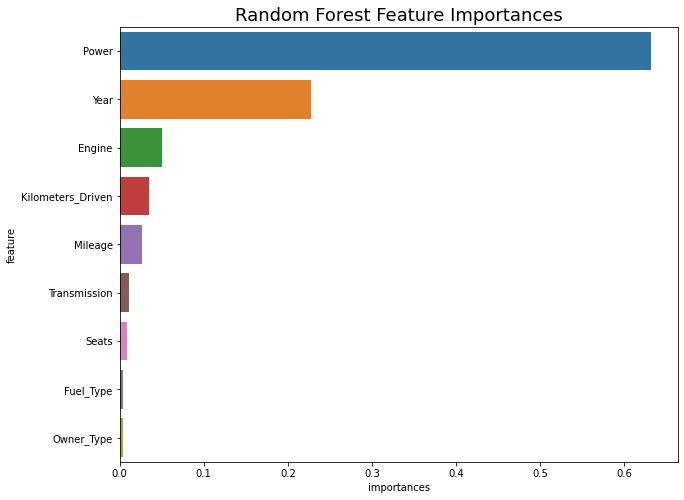

In [ ]:
# 특성 중요도 시각화

plt.figure(figsize=(10, 8))
sns.barplot(x='importances', y='feature', data=importances)
plt.title('Random Forest Feature Importances', fontsize=18)
plt.show()

In [ ]:
!pip install --upgrade eli5

In [ ]:
# Permutaion Importance

import eli5
from eli5.sklearn import PermutationImportance

# Permutation Importance
pipe2 = make_pipeline(OrdinalEncoder(),
                      SimpleImputer())
                    
X_train_t = pipe2.fit_transform(X_train)
X_val_t = pipe2.transform(X_val)

rf = RandomForestRegressor().fit(X_train_t, y_train)
perm_imp = PermutationImportance(rf, scoring='r2', random_state=2)
perm_imp.fit(X_val_t, y_val)

perm_imp_df = pd.DataFrame()
perm_imp_df["feature"] = feature
perm_imp_df["importance"] = perm_imp.feature_importances_
perm_imp_df.sort_values(by='importance', ascending=False, inplace=True)
perm_imp_df.reset_index(drop=True, inplace=True)
perm_imp_df

,feature,importance
0,Power,0.874537
1,Year,0.457195
2,Engine,0.093327
3,Mileage,0.031706
4,Transmission,0.017061
5,Kilometers_Driven,0.016967
6,Seats,0.006912
7,Fuel_Type,0.005085
8,Owner_Type,0.001362


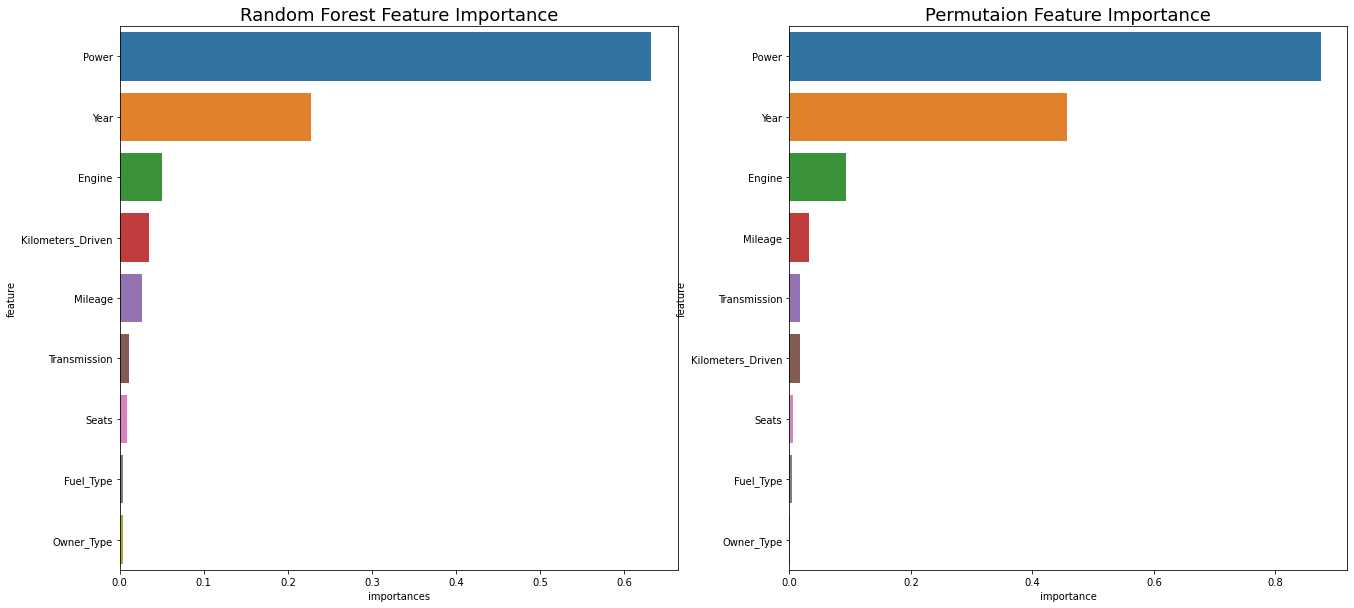

In [ ]:
# Radom Forest 중요도 / 순열 중요도 비교

fig, axes = plt.subplots(1, 2, figsize=(22, 10))
plt.rcParams.update({'font.size':10})
sns.barplot(x='importances', y='feature', data=importances, ax=axes[0])
axes[0].set_title('Random Forest Feature Importance', fontsize=18)

sns.barplot(x='importance', y='feature', data=perm_imp_df, ax=axes[1])
axes[1].set_title('Permutaion Feature Importance', fontsize=18)

plt.show()

In [ ]:
eli5.show_weights(perm_imp, feature_names = list(feature))

Weight,Feature
0.8745 ± 0.0359,Power
0.4572 ± 0.0441,Year
0.0933 ± 0.0092,Engine
0.0317 ± 0.0044,Mileage
0.0171 ± 0.0078,Transmission
0.0170 ± 0.0020,Kilometers_Driven
0.0069 ± 0.0023,Seats
0.0051 ± 0.0016,Fuel_Type
0.0014 ± 0.0006,Owner_Type
